<a href="https://colab.research.google.com/github/damianomarsili/temp/blob/main/NavierStokes_FastMarching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive & cd into project folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/ML\ Project

/content/drive/MyDrive/ML Project


Install dependencies

In [ ]:
pip install opencv-python && pip install numpy && pip install scipy && pip install tensorflow

     |████████████████████████████████| 462 kB 13.9 MB/s 


As a test we check our implementation for one image

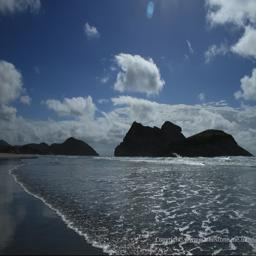

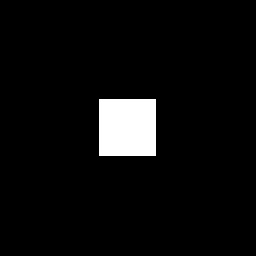

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

original_img = cv2.imread('Dataset/0/original/00000002.jpg')
mask = cv2.imread('blank_mask.jpg', 0)

cv2_imshow(original_img)
cv2_imshow(mask)

Check Inpainting implementations

Navier Stokes: 


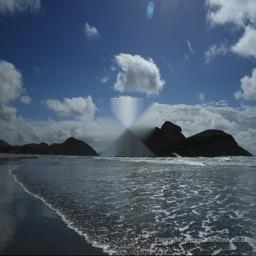


Fast Marching: 


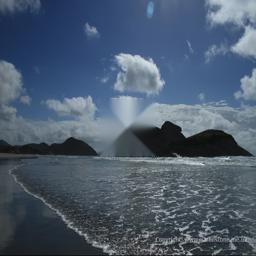

In [ ]:
nv_stokes = cv2.inpaint(original_img, mask, 3, cv2.INPAINT_NS)
fm = cv2.inpaint(original_img, mask, 3, cv2.res_FSRFAST)

print("Navier Stokes: ")
cv2_imshow(nv_stokes)
print()
print("Fast Marching: ")
cv2_imshow(fm)

Since we are confident our analytical implementations work, we now define the Frechlet Inception Distance

In [ ]:
from scipy.linalg import sqrtm

def fid(inception_model, imgs1, imgs2):
  # Extract convolutions from inception model
  conv1 = inception_model.predict(imgs1)
  conv2 = inception_model.predict(imgs2)

  # Compute mean & cov
  m1, cov1 = conv1.mean(axis=0), np.cov(conv1, rowvar=False)
  m2, cov2 = conv2.mean(axis=0), np.cov(conv2, rowvar=False)

  # Sum squared difference of means
  ss = np.sum((m1 - m2) ** 2)
  
  # Square root of cov product
  mean_cov = sqrtm(cov1.dot(cov2))

  # Sanity check for im numbers
  if np.iscomplexobj(mean_cov):
    mean_cov = mean_cov.real
  
  FID = ss + np.trace(cov1 + cov2 - 2.0 * mean_cov)
  return FID 


Import all original images

In [ ]:
import os
import tensorflow as tf

original_imgs = []

# Import all images from dataset
count = 0
for filename in os.listdir('Dataset/0/original/'):
  if (count >= 100):
    break
  img = cv2.imread(os.path.join('Dataset/0/original/', filename))
  if img is not None:
    original_imgs.append(img)
    count += 1


Create inpainted images

In [ ]:
# Compute analytical inpaints for all images
nv_imgs = []
fm_imgs = []

for im in original_imgs:
  nv_imgs.append(cv2.inpaint(im, mask, 3, cv2.INPAINT_NS))
  fm_imgs.append(cv2.inpaint(im, mask, 3, cv2.INPAINT_TELEA))

100
(256, 256, 3)


Convert images lists to np arrays & init model

In [ ]:
# Convert to np arrays
original_imgs = np.array(original_imgs)
nv_imgs = np.array(nv_imgs)
fm_imgs = np.array(fm_imgs)

# Define the inception model
model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, pooling='avg', input_shape = (256,256,3))

(100, 256, 256, 3)
(100, 256, 256, 3)
(100, 256, 256, 3)
87924736/87910968 [==============================] - 1s 0us/step


Preprocess the inputs

In [ ]:
# Preprocess input
original_imgs = tf.keras.applications.inception_v3.preprocess_input(original_imgs)
nv_imgs = tf.keras.applications.inception_v3.preprocess_input(nv_imgs)
fm_imgs = tf.keras.applications.inception_v3.preprocess_input(fm_imgs)

Compute FID's

In [ ]:
# Compute FID's 
nv_fid = fid(model, original_imgs, nv_imgs)
fm_fid = fid(model, original_imgs, fm_imgs)

print("Navier Stokes FID:", nv_fid)
print("Fast Marching FID:", fm_fid)

Navier Stokes FID: 106.28667260750234
Fast Marching FID: 117.18291223903748
